In [2]:
# *torch
from pickletools import optimize
# from sched import scheduler
import torch
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler as scheduler
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader

# *transformers
from transformers import MBartForConditionalGeneration, MBartTokenizer, MBartConfig


import utils as utils


# *basic
import os
import time
import shutil
import json, datetime
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import yaml
import random
import wandb
import copy
from pathlib import Path
import math
import sys
from typing import Iterable, Optional
from loguru import logger

from sacrebleu.metrics import BLEU, CHRF, TER

# *timm
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler
from timm.utils import NativeScaler
from timm.loss import SoftTargetCrossEntropy
from timm.optim import AdamW

# visualization
from torchvision.utils import save_image, make_grid
from PIL import Image
import argparse
from hpman.m import _
import hpargparse

# global definition
from definition import *

import gzip
import pickle
import torch


In [3]:

from prep_args import * 
parser = argparse.ArgumentParser('Visual-Language-Pretraining (VLP) V2 scripts', parents=[get_args_parser()])

hpargparse.bind(parser, _)
args = parser.parse_args()
args

darwin


Namespace(batch_size=8, epochs=80, finetune='/Users/tannicholas/Library/Jupyter/runtime/kernel-v2-121984zAaD9VIhPyz.json', opt='adamw', opt_eps=1e-09, opt_betas=None, clip_grad=None, momentum=0.9, weight_decay=0.0, sched='cosine', lr=0.001, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, warmup_lr=1e-06, min_lr=1e-08, decay_epochs=30, warmup_epochs=0, cooldown_epochs=10, patience_epochs=10, decay_rate=0.1, output_dir='', device='mps', seed=0, resume='', start_epoch=0, eval=False, num_workers=0, pin_mem=False, config='./config_gloss_free_CSL_daily.yaml', input_size=224, resize=256, log_all=False, entity=None, project='VLP', training_refurbish=True, noise_rate=0.15, noise_type='omit_last', random_shuffle=False, loss_lambda=1.0, hp_save=None, hp_load=None, hp_list=None, hp_detail=False, hp_serial_format='auto', hp_exit=False)

In [4]:
with open(args.config, 'r+', encoding='utf-8') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

config

{'name': 'GFSLT-VLP CSL-Daily',
 'data': {'train': '../../CSL-Daily/sentence_label/processed/labels_train.pkl',
  'dev': '../../CSL-Daily/sentence_label/processed/labels_dev.pkl',
  'test': '../../CSL-Daily/sentence_label/processed/labels_test.pkl',
  'img_path': '../../CSL-Daily/sentence/frames_512x512/',
  'max_length': 300},
 'training': {'wandb': 'disabled',
  'scale_embedding': False,
  'tgt_lang': 'zh_CN'},
 'model': {'transformer': 'facebook/mbart-large-50-many-to-many-mmt',
  'visual_encoder': '../pretrain_models/mytran',
  'sign_proj': True}}

In [1]:
from transformers import MBart50Tokenizer, MBartForConditionalGeneration

# Load the MBART tokenizer
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
# Example: Chinese sentences from the CSL-daily dataset
texts = ["这是一个例子句子。", "这是另一个例子句子。"]
print("tokenizer tgt lang", tokenizer.tgt_lang)
# Tokenize the Chinese text data
tokenized_texts = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
print (tokenized_texts)
input_ids = tokenized_texts['input_ids']
print(input_ids)
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
output = model.generate(input_ids, max_length=50)
generated_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print(generated_text)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tokenizer tgt lang None
{'input_ids': tensor([[250004,      6, 100013, 101676,  27683,   1344,     30,      2,      1],
        [250004,      6,   8513,  83757, 101676,  27683,   1344,     30,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[250004,      6, 100013, 101676,  27683,   1344,     30,      2,      1],
        [250004,      6,   8513,  83757, 101676,  27683,   1344,     30,      2]])


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [6]:
import importlib
import data_classes
importlib.reload(data_classes)
from data_classes import * 

train_dataset = S2T_Dataset(tokenizer, config, args, 'train', training_refurbish = False)
print(len(train_dataset.raw_data['info'])) 

18401


In [7]:
train_dataset[10000][1].shape

torch.Size([109, 3, 224, 224])

In [8]:
parser = argparse.ArgumentParser('Visual-Language-Pretraining (VLP) V2 scripts', parents=[get_args_parser()])
hpargparse.bind(parser, _)
args = parser.parse_args()

with open(args.config, 'r+', encoding='utf-8') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

darwin


In [9]:
import create_dataloaders
import importlib
importlib.reload(create_dataloaders)
from create_dataloaders import * 
import prep_args

trainloader, devloader, testloader = create_dataloaders(config, args)
for batch, (src_input, tgt_input, masked_tgt_input) in enumerate(trainloader): 
    print("WHERE U GO ", src_input['input_ids'].shape)

/opt/homebrew/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Creating datasets:
#total train set: 18401.
trainloader dataset length #total train set: 18401.
2301
#total dev set: 1077.
135
#total test set: 1176.
147


/opt/homebrew/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Max video length before padding: 76
Max length after padding: torch.Size([68, 3, 224, 224])
after processing batch size: torch.Size([480, 3, 224, 224])
src length batch total: <built-in method sum of Tensor object at 0x2ac2e3a10>
About to tokenize the batch...
done with tokenizing the batch 
about to inject noise into training data...
noise injection complete 
WHERE U GO  torch.Size([480, 3, 224, 224])
Max video length before padding: 84
Max length after padding: torch.Size([68, 3, 224, 224])
after processing batch size: torch.Size([508, 3, 224, 224])
src length batch total: <built-in method sum of Tensor object at 0x2ac2e3fb0>
About to tokenize the batch...
done with tokenizing the batch 
about to inject noise into training data...
noise injection complete 
WHERE U GO  torch.Size([508, 3, 224, 224])
Max video length before padding: 116
Max length after padding: torch.Size([72, 3, 224, 224])
after processing batch size: torch.Size([616, 3, 224, 224])
src length batch total: <built-in m

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1179)


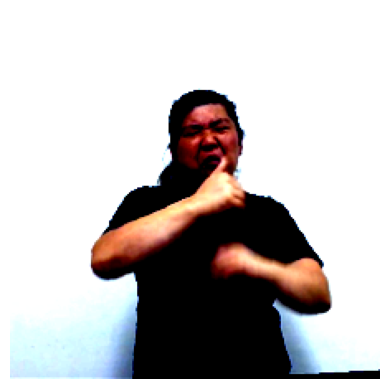

In [29]:
import numpy as np
import matplotlib.pyplot as plt

image_matrix = trainloader.dataset[1200][1][20]
# Transpose to (height, width, 3) for display
image_matrix = np.transpose(image_matrix, (1, 2, 0))
print(image_matrix.min())
# Display the image
plt.imshow(image_matrix)
plt.axis('off')
plt.show()

In [ ]:
len(trainloader)

1

In [ ]:
print(train_dataset[10000][1].shape)

img directory:  ../../CSL-Daily/sentence/frames_512x512/train/S004184_P0002_T00
torch.Size([512, 3, 224, 224])


In [ ]:
len(train_dataset) #.size()

2

In [ ]:
len(train_dataset[0])

3

In [ ]:
train_dataset[0][0], train_dataset[0][1].size(), train_dataset[0][2] 

('S000000_P0000_T00', torch.Size([52, 3, 224, 224]), '你们好！')

In [ ]:
i = 16000

print(train_dataset[i][0], train_dataset[i][1].size(), train_dataset[i][2] ) 

S006389_P0000_T00 torch.Size([140, 3, 224, 224]) 很多年轻人不懂得克制自己的情感。


In [ ]:
train_dataset.max_length

493